In [358]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import numpy as np
import numpy.linalg as l
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math  
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize._lsq.least_squares import arctan
matplotlib.rcParams.update({'font.size': 8})


# Initialisation

In [359]:
u_max = 1
p_a = 11
r0 = np.array([12.0,8.0,0.0])
v0 = np.array([0,0,0])
x0 = np.array([r0,v0]).reshape(-1)

k1 = 0.5
k2 = 0.1
k3 = 0.1

tf = 100 


# Fonctions


In [360]:
#Pour afficher une barre de progression (cosmétique)
def progress(i, n):
    i += 1
    k = int(i/n*20)
    print(f'\rProgression:[{k*"#"}{(20-k)*" "}] [{(i/n*100):.0f} %]',
          end='' if i != n else "\n", flush=True)
    
f  = lambda x : np.array([x[3],x[4],x[5],0,0,0])
g = np.zeros((6,3))
g[3:6,:] = np.eye(3)


# TEST V


In [361]:
def r_p(t) : 
    phi  = -np.pi/12
    theta_dot =  0
    theta = np.pi/4 + theta_dot * t
    r_g = 10 
    res1 = r_g * np.array([np.cos(phi)*np.cos(theta), np.cos(phi)*np.sin(theta), np.sin(phi)])
    res2 = r_g * theta_dot * np.array([- np.cos(phi)*np.sin(theta), np.cos(phi)*np.cos(theta), 0])
    return res1,res2

def V(x,t) : 
    r = x[:3]
    v = x[3:] 
    b = r - r_p(t)[0]
    a = v - k1 * b
    res = b@b / 2 + k2 / 2 * a@a
    return res
    
def V_p(x,t) : 
    rp = r_p(t)[0]
    r = x[:3]
    v = x[3:]
    dVdr = r - rp - k2*k1 * (v - k1 * (r - rp))
    dVdv = k2 * (v - k1 * (r - rp))
    return np.array([dVdr, dVdv]).reshape(-1)

def L_fV(x,t) : 
    return np.dot(V_p(x,t),f(x))

def L_gV(x,t) : 
    return np.dot(V_p(x,t),g)
    
    
print(V(x0,15))
print(r_p(10)[0],r_p(0)[0])


17.83239611209503
[ 6.83012702  6.83012702 -2.58819045] [ 6.83012702  6.83012702 -2.58819045]


# Fonction animation + plot

In [362]:
def main(s,x0,name) : 
    sol = s


    def init():
        ax.set(xlim=(-15,15),ylim=(-15,15),zlim=(-10,10))
        legend = ax.legend(loc="upper left", shadow = True)
        legend.get_frame().set_facecolor('C0')
        ax.scatter(x0[0],x0[1],x0[2],color="g",label="Point de départ")
        ax.scatter(r_p(0)[0][0],r_p(0)[0][1],r_p(0)[0][2],color="b",label="Point de départ")
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = p_a*np.cos(u)*np.sin(v) 
        y = p_a*np.sin(u)*np.sin(v)
        z = p_a*np.cos(v)
        ax.plot_wireframe(x, y, z, color="k",label="Obstacle")
        #ax.set_aspect('equal')
        return lines


    def update_lines(num, data, lines,points):
        for dat,line, point in zip(data,lines,points):
            line.set_data(dat[0:2, :num+1])
            line.set_3d_properties(dat[2, :num+1])
            
        return lines

    # Attaching 3D axis to the figure
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca(projection='3d')

    X = [e[0] for e in sol]
    Y = [e[1] for e in sol]
    Z = [e[2] for e in sol]
    data = np.array([[X,Y,Z]])

    lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], 'm')[0] for dat in data]
    points = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], 'ro')[0] for dat in data]

    line_ani = animation.FuncAnimation(fig, update_lines,len(sol), fargs=(data, lines,points),
                                    interval=10, init_func=init, blit=True, repeat=True)
    writergif = animation.PillowWriter(fps=int(len(sol)/3))
    line_ani.save('test'+name+'.gif',writer=writergif)



def fctplot(sol) :

    tablex = []
    tabley = []
    tablez = []
    for i in range(0,len(sol)): 
        tablex.append(sol[i][0]) 
        tabley.append(sol[i][1])
        tablez.append(sol[i][2])
    X = np.array(tablex)
    Y = np.array(tabley)
    Z = np.array(tablez)


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(X, Y, Z, color="r",label="Trajectoire")
    ax.scatter(x0[0],x0[1],x0[2],color="g",label="Point de départ")
    # ax.scatter(r_p(0)[0],r_p(0)[1],r_p(0)[2],color="g",label="Point de départ")
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = p_a*np.cos(u)*np.sin(v) 
    y = p_a*np.sin(u)*np.sin(v)
    z = p_a*np.cos(v)
    ax.plot_wireframe(x, y, z, color="k",label="Obstacle")

    ax.set(xlim=(-15,15),ylim=(-15,15))

    plt.show()

# Dynamique 2 


In [368]:
def dynamic_int2(t,x):
    # progress(t, tf)

    r = x[:3]
    v = x[3:]

    def cost_func(params) :
        return -L_gV(x,t)@params 

    cons = NonlinearConstraint(lambda u : l.norm(u),-u_max, u_max)
    res = minimize(cost_func,u0,method ='SLSQP', constraints=cons)

    r_dot = v
    v_dot = res.x
    # print(-L_gV(x,t),"Contrôle pour t = ",t," : ",v_dot)
    return np.array([r_dot,v_dot]).reshape(-1)


In [364]:
r0 = r_p(0)[0] + 10*np.ones(3)
v0 = np.array([0,0,0])
x0 = np.array([r0,v0]).reshape(-1)

print(-L_gV(x0,0))

[0.5 0.5 0.5]


In [369]:
tf = 100
u0 = np.array([0,0,0])
t= [0,tf]
r0 = r_p(0)[0]+ 5*np.ones(3)
v0 = np.array([0,0,0])
x0 = np.array([r0,v0]).reshape(-1)


res = solve_ivp(dynamic_int2,t,x0,max_step=0.5)

# Plot 

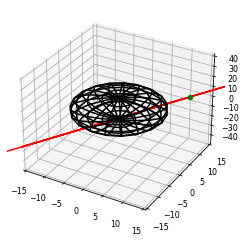

C:\Users\etsit\AppData\Local\Temp/ipykernel_43992/2884313663.py:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
No handles with labels found to put in legend.


In [370]:
fctplot(res.y.T)
main(res.y.T,x0,"n")